Epoch 0: Loss = 0.969244
Epoch 500: Loss = 0.000044
Epoch 1000: Loss = 0.000060
Epoch 1500: Loss = 0.000021
Epoch 2000: Loss = 0.000015
Epoch 2500: Loss = 0.000018
Epoch 3000: Loss = 0.000008
Epoch 3500: Loss = 0.000006
Epoch 4000: Loss = 0.000004
Epoch 4500: Loss = 0.000004
Epoch 5000: Loss = 0.000003


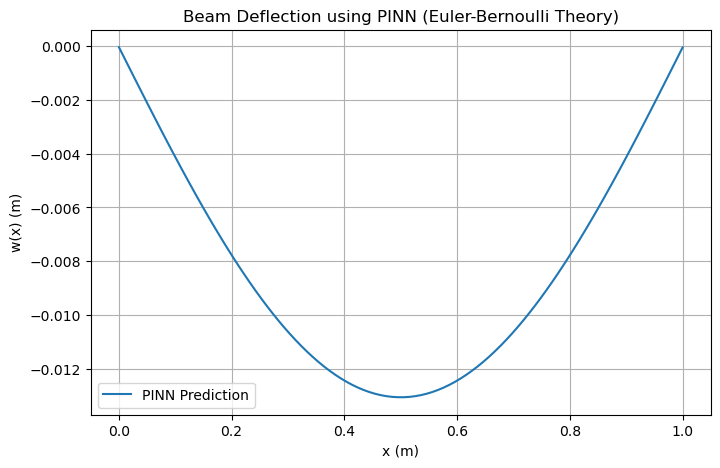

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Simple Feedforward Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=40, output_size=1, depth=4):
        super(SimpleNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(hidden_size, hidden_size), nn.Tanh()]
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# PINN class for beam deflection
class BeamPINN:
    def __init__(self, EI=1.0, q0=-1.0, L=1.0):
        self.EI = EI
        self.q0 = q0
        self.L = L

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SimpleNN().to(self.device)

        # Training points
        N_train = 200
        x = torch.linspace(0, L, N_train).unsqueeze(1).to(self.device)
        x.requires_grad = True
        self.x_train = x

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()

    def compute_pde_loss(self):
        x = self.x_train
        w = self.model(x)

        # Compute derivatives
        dw = torch.autograd.grad(w, x, grad_outputs=torch.ones_like(w), create_graph=True)[0]
        d2w = torch.autograd.grad(dw, x, grad_outputs=torch.ones_like(dw), create_graph=True)[0]
        d3w = torch.autograd.grad(d2w, x, grad_outputs=torch.ones_like(d2w), create_graph=True)[0]
        d4w = torch.autograd.grad(d3w, x, grad_outputs=torch.ones_like(d3w), create_graph=True)[0]

        pde_residual = self.EI * d4w - self.q0
        return self.criterion(pde_residual, torch.zeros_like(pde_residual))

    def compute_bc_loss(self):
        x0 = torch.tensor([[0.0]], requires_grad=True, device=self.device)
        xL = torch.tensor([[self.L]], requires_grad=True, device=self.device)

        w0 = self.model(x0)
        wL = self.model(xL)

        d2w0 = torch.autograd.grad(torch.autograd.grad(self.model(x0), x0, create_graph=True)[0],
                                   x0, create_graph=True)[0]
        d2wL = torch.autograd.grad(torch.autograd.grad(self.model(xL), xL, create_graph=True)[0],
                                   xL, create_graph=True)[0]

        return (
            self.criterion(w0, torch.tensor([[0.0]], device=self.device)) +
            self.criterion(wL, torch.tensor([[0.0]], device=self.device)) +
            self.criterion(d2w0, torch.tensor([[0.0]], device=self.device)) +
            self.criterion(d2wL, torch.tensor([[0.0]], device=self.device))
        )

    def train(self, epochs=5001):
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            loss = self.compute_pde_loss() + self.compute_bc_loss()
            loss.backward()
            self.optimizer.step()

            if epoch % 500 == 0:
                print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

    def predict(self, x_vals):
        x_tensor = torch.tensor(x_vals, dtype=torch.float32).unsqueeze(1).to(self.device)
        with torch.no_grad():
            w_pred = self.model(x_tensor).cpu().numpy()
        return w_pred

# Instantiate and train the PINN
pinn = BeamPINN()
pinn.train(epochs=5001)

# Plotting the predicted deflection
x_vals = np.linspace(0, 1, 100)
w_vals = pinn.predict(x_vals)

plt.figure(figsize=(8, 5))
plt.plot(x_vals, w_vals, label='PINN Prediction')
plt.xlabel('x (m)')
plt.ylabel('w(x) (m)')
plt.title('Beam Deflection using PINN (Euler-Bernoulli Theory)')
plt.grid(True)
plt.legend()
plt.show()


In [3]:
print(pinn.predict([0.5]))

[[-0.01306146]]
